# Retail RFM Analysis

This notebook explores RFM (Recency, Frequency, Monetary Value) analysis and customer segmentation via unsupervised clustering. The dataset itself came from a [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Online+Retail+II), and contains nearly three years of UK-based online retail store transactions (01/12/2009 to 09/12/2011). The general overview of steps taken are as follows:

    - data cleaning: removing nulls, formatting values, and any other housekeeping
    - rfm analysis: three subsections, one for each letter; broken down by customer id
        > recency: days since most recent transaction
        > frequency: total number of transactions
        > monetary value: total revenue amount
    - customer segmentation: attaching labels to customer clusters, mitigation steps


## Data Cleaning

Pretty standard data prep here, the only standout step would be the removal of cancelled transactions (those that begin with 'c').

In [1]:
# global module imports
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from sklearn.cluster import KMeans

In [2]:
# downloading uci dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx'

f = requests.get(url)

open('online_retail_ii.xlsx', 'wb').write(f.content)

45622278

In [3]:
# importing excel file
df = pd.read_excel('online_retail_ii.xlsx')
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


In [4]:
# dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [5]:
# data integrity checks
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

Missing descriptions won't impact our analysis, though the same cannot be said about customer ids. These will need to be dropped, resulting in a loss of roughly 20% of our dataset.

In [6]:
# removing incomplete rows
df.dropna(subset = ['Customer ID'], inplace = True)
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

The UCI repo notes that invoices starting with the letter 'c' indicate a cancellation, so these will also need to be dropped.

In [7]:
# pruning cancelled transactions
df = df.query('Invoice.str[0] not in ["c", "C"]')

In [8]:
# dropping unnecessary columns
df = df.loc[:, ['Customer ID', 'InvoiceDate', 'Price', 'Quantity']]
print(f'Final dataframe shape: {df.shape}')

Final dataframe shape: (407695, 4)


In [9]:
# reformatting datetime column
df.InvoiceDate = df.InvoiceDate.dt.date
df

,Customer ID,InvoiceDate,Price,Quantity
0,13085.0,2009-12-01,6.95,12
1,13085.0,2009-12-01,6.75,12
2,13085.0,2009-12-01,6.75,12
3,13085.0,2009-12-01,2.10,48
4,13085.0,2009-12-01,1.25,24
...,...,...,...,...
525456,17530.0,2010-12-09,2.95,2
525457,17530.0,2010-12-09,3.75,1
525458,17530.0,2010-12-09,3.75,1
525459,17530.0,2010-12-09,3.75,2


## RFM Analysis

Each of the three components of RFM will be calcuated and clustered individually, then compiled into a final cluster for customer segmentation. Frequency might be the only component that isn't quite as straightforward, as there are multiple decent options of re-encoding 'InvoiceDate' into a meaningful feature.

### Recency

Best defined as the time between each customer's last transaction time and the last date of this dataset, this ranges from 0 downwards to -373 days.

In [10]:
# recency calculation
df['Recency'] = df.InvoiceDate - df.InvoiceDate.max()
temp = df.groupby('Customer ID')['Recency'].max()

In [11]:
# merging with unique customer ids
df_rfm = pd.DataFrame(df['Customer ID'].unique(), columns = ['Customer ID'])
df_rfm = df_rfm.merge(temp, how = 'left', left_on = 'Customer ID', right_index = True)
df_rfm.Recency = df_rfm.Recency.apply(lambda x: x.days)
df_rfm

,Customer ID,Recency
0,13085.0,-314
1,13078.0,-1
2,15362.0,-83
3,18102.0,0
4,12682.0,0
...,...,...
4309,18269.0,-1
4310,13270.0,-1
4311,12942.0,0
4312,13369.0,0


In [12]:
# ordered clustering function
def ordered_clusters(series, clusters = 5, ascending = True):
    '''
    Clusters passed values then re-orders labels based on ascending flag.

        Arguments:
            series (list-like): values to cluster
            clusters (int): number of clusters
            ascending (bool): order to sort in
        
        Returns:
            sorted (list-like): ordered labels for series
    '''

    labels = KMeans(n_clusters = clusters, random_state = 42).fit(np.array(series).reshape(-1, 1)).labels_
    df_rfm['labels'] = labels
    val = 1 if ascending else -1
    order = np.argsort(val*df_rfm.groupby('labels')['Recency'].mean())
    df_rfm.drop('labels', inplace = True, axis = 1)
    reps = {j:i for i, j in zip(order.index, order.values)}
    labels = [reps[i] for i in labels]
    return labels

In [13]:
# adding labels to df
df_rfm['RecencyScore'] = ordered_clusters(df_rfm.Recency)
df_rfm

,Customer ID,Recency,RecencyScore
0,13085.0,-314,0
1,13078.0,-1,4
2,15362.0,-83,3
3,18102.0,0,4
4,12682.0,0,4
...,...,...,...
4309,18269.0,-1,4
4310,13270.0,-1,4
4311,12942.0,0,4
4312,13369.0,0,4


Since clusters are unsupervised, labels are assigned somewhat haphazardly. To bake in some ordinal meaning to our cluster labels, labels are modified based on within-cluster mean values; higher labels signify a more desirable customer / better score.

### Frequency

As mentioned above, there are a couple ways of quantifying customer frequency. While this section relies on pure transaction count, a good alternative would be to assess average days between customer transactions.

In [14]:
# frequency calculation
temp = df.groupby('Customer ID').InvoiceDate.count()
temp = temp.rename('Frequency')
df_rfm = df_rfm.merge(temp, how = 'left', left_on = 'Customer ID', right_index = True)
df_rfm

,Customer ID,Recency,RecencyScore,Frequency
0,13085.0,-314,0,62
1,13078.0,-1,4,443
2,15362.0,-83,3,40
3,18102.0,0,4,627
4,12682.0,0,4,514
...,...,...,...,...
4309,18269.0,-1,4,7
4310,13270.0,-1,4,1
4311,12942.0,0,4,16
4312,13369.0,0,4,14


In [15]:
# frequency ordered clusters
df_rfm['FrequencyScore'] = ordered_clusters(df_rfm.Frequency)
df_rfm

,Customer ID,Recency,RecencyScore,Frequency,FrequencyScore
0,13085.0,-314,0,62,0
1,13078.0,-1,4,443,2
2,15362.0,-83,3,40,0
3,18102.0,0,4,627,2
4,12682.0,0,4,514,2
...,...,...,...,...,...
4309,18269.0,-1,4,7,0
4310,13270.0,-1,4,1,0
4311,12942.0,0,4,16,0
4312,13369.0,0,4,14,0


### Monetary Value

Since no data on company profits per good was provided in this dataset, monetary value is only being looked at from an overall revenue standpoint. Profit margins per product may not all align, leading to some customers who may score high marks in overall revenue while turning a small (or even negative) profit.

In [16]:
# monetary value calculation
df['OrderTotal'] = df.Price * df.Quantity
temp = df.groupby('Customer ID')['OrderTotal'].sum()
temp = temp.rename('MonetaryValue')
df_rfm = df_rfm.merge(temp, how = 'left', left_on = 'Customer ID', right_index = True)
df_rfm

,Customer ID,Recency,RecencyScore,Frequency,FrequencyScore,MonetaryValue
0,13085.0,-314,0,62,0,2017.20
1,13078.0,-1,4,443,2,16904.51
2,15362.0,-83,3,40,0,613.08
3,18102.0,0,4,627,2,349164.35
4,12682.0,0,4,514,2,11745.69
...,...,...,...,...,...,...
4309,18269.0,-1,4,7,0,168.60
4310,13270.0,-1,4,1,0,590.00
4311,12942.0,0,4,16,0,258.75
4312,13369.0,0,4,14,0,308.28


In [17]:
# monetary value ordered clusters
df_rfm['MonetaryValueScore'] = ordered_clusters(df_rfm.MonetaryValue)
df_rfm

,Customer ID,Recency,RecencyScore,Frequency,FrequencyScore,MonetaryValue,MonetaryValueScore
0,13085.0,-314,0,62,0,2017.20,0
1,13078.0,-1,4,443,2,16904.51,1
2,15362.0,-83,3,40,0,613.08,0
3,18102.0,0,4,627,2,349164.35,4
4,12682.0,0,4,514,2,11745.69,1
...,...,...,...,...,...,...,...
4309,18269.0,-1,4,7,0,168.60,0
4310,13270.0,-1,4,1,0,590.00,0
4311,12942.0,0,4,16,0,258.75,0
4312,13369.0,0,4,14,0,308.28,0


## Customer Segmentation

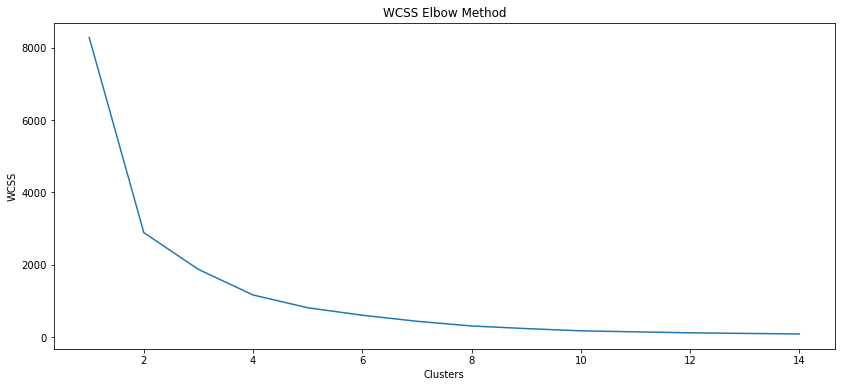

In [18]:
# tuning cluster count
wcss = []
X_train = df_rfm.loc[:, ['RecencyScore', 'FrequencyScore', 'MonetaryValueScore']].to_numpy(dtype = 'int')
for i in range(1, 15):
    wcss.append(KMeans(n_clusters = i, random_state = 42).fit(X_train).inertia_)
fig, ax = plt.subplots()
fig.set_size_inches(14, 6)
ax.plot(range(1, 15), wcss)
ax.set_title('WCSS Elbow Method')
ax.set_xlabel('Clusters')
ax.set_ylabel('WCSS')
plt.show()

This section is a bit more loosely defined, since the number of clusters here would likely be defined in the business requirements. Nonetheless, a quick elbow method highlights an optimal cluster count of 4. 

In [19]:
# differentiating clusters by features
labels = KMeans(n_clusters = 4, random_state = 42).fit(X_train).labels_
df_rfm['Segment'] = labels
df_rfm.groupby('Segment')['RecencyScore', 'FrequencyScore', 'MonetaryValueScore'].mean()

<ipython-input-19-a71baed3d0cb>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_rfm.groupby('Segment')['RecencyScore', 'FrequencyScore', 'MonetaryValueScore'].mean()


,RecencyScore,FrequencyScore,MonetaryValueScore
Segment,,,
0,3.971388,1.246066,0.257511
1,2.693099,0.105932,0.010896
2,0.619174,0.019973,0.011984
3,4.000000,0.000000,0.019802


Labels for each of the above four segments could be as follows:

    0. Ole reliable: your most reliable and largest revenue producing crowd; those most worth keeping happy (also likely highest lifetime value customers)
    1. Needs encouragement: recent shoppers who are semi-reliable; lower lifetime value than above but still potentially worth chasing
    2. Lost cause: likely one-and-done shoppers from a while back, the least likely to become valuable customers; lowest lifetime value
    3. The backup's backup: recent new shoppers, high risk and potentially high reward; second lowest lifetime value

Keep in mind that while the above descriptions are subjective, they do stand in as reasonable interpretations of the customer segmentation results. They help to paint a picture of the four largest customer segments and their likely purchasing behaviour. They also imply a rough order of lifetime value, signaling which segments are worth spending more money to retain.